In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import expm1
from pyspark.sql.functions import col

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson

In [3]:
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

24/08/23 13:53:29 WARN Utils: Your hostname, apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.11.182 instead (on interface en0)
24/08/23 13:53:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/23 13:53:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df_train = spark.read.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development')

In [5]:
rmse_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='rmse')
mae_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='mae')
r2_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')

In [6]:
df_train.count()

4393759

In [7]:
df_train = df_train.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')

In [8]:
# df_train.columns

In [10]:
relevant_columns = ['VendorID',
                    'trip_distance',
                    'RatecodeID',
                    'PULocationID',
                    'DOLocationID',
                    'mta_tax',
                    'tolls_amount',
                    'improvement_surcharge',
                    'congestion_surcharge',
                    'airport_fee',
                    'pickup_hour',
                    'pickup_dayofweek',
                    'days_since_2022_11_01',
                    'dropoff_at_airport',
                    'pickup_at_tourist_attraction',
                    'dropoff_at_tourist_attraction',
                    'is_holiday_season',
                    'is_event_day',
                    'avg_temp',
                    ]


train_data = df_train.filter(col('days_since_2022_11_01').between(0, 143))
test_data = df_train.filter(col('days_since_2022_11_01').between(144, 180))

In [11]:
fare_assembler = VectorAssembler(inputCols=relevant_columns, outputCol='unscaled_features')
fare_train_assembled = fare_assembler.transform(train_data)
fare_test_assembled = fare_assembler.transform(test_data)

In [12]:
fare_scaler = StandardScaler(inputCol='unscaled_features', outputCol='scaled_features')
fare_scaler_model = fare_scaler.fit(fare_train_assembled)
fare_train_scaled = fare_scaler_model.transform(fare_train_assembled).select('scaled_features', 'fare_amount')
fare_test_scaled = fare_scaler_model.transform(fare_test_assembled).select('scaled_features', 'fare_amount')

24/08/23 13:56:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
fare_train_scaled.count()

4392592

In [14]:
lr = LinearRegression(featuresCol='scaled_features', labelCol='fare_amount')
lr_model = lr.fit(fare_train_scaled)

24/08/23 13:56:44 WARN Instrumentation: [7e89f186] regParam is zero, which might cause numerical instability and overfitting.
24/08/23 13:56:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/23 13:56:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [57]:
lr_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/linear_model")

In [15]:
lr_predictions = lr_model.transform(fare_test_scaled)

lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_mae = mae_evaluator.evaluate(lr_predictions)
lr_r2 = r2_evaluator.evaluate(lr_predictions)
print(f"Linear Regression on test_data - RMSE: {lr_rmse}, MAE: {lr_mae}, R2: {lr_r2}")

Linear Regression on test_data - RMSE: 7.461147925698806, MAE: 3.8167371871369884, R2: 0.779496636743635


In [16]:
predictions_and_residuals = lr_predictions.select("prediction", "fare_amount").withColumn("residuals", lr_predictions["fare_amount"] - lr_predictions["prediction"])
predictions_and_residuals_pd = predictions_and_residuals.toPandas()

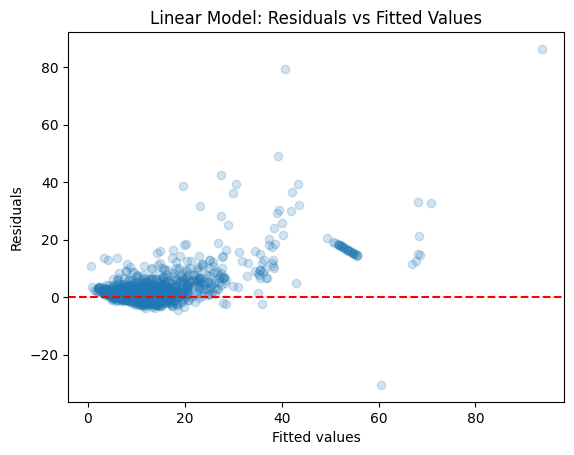

In [17]:
plt.scatter(predictions_and_residuals_pd['prediction'], predictions_and_residuals_pd['residuals'], alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Linear Model: Residuals vs Fitted Values')
plt.show()

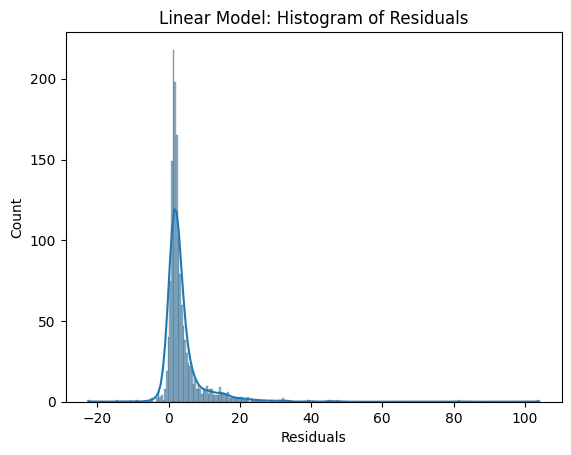

In [46]:
sns.histplot(predictions_and_residuals_pd['residuals'], kde=True)
plt.xlabel('Residuals')
plt.title('Linear Model: Histogram of Residuals')
plt.show()

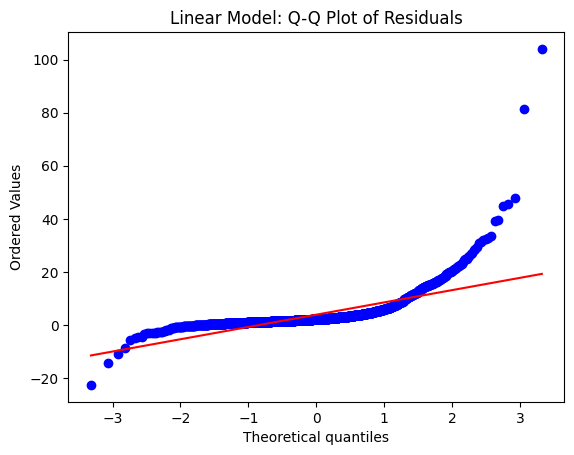

In [47]:
probplot(predictions_and_residuals_pd['residuals'], dist="norm", plot=plt)
plt.title('Linear Model: Q-Q Plot of Residuals')
plt.show()

In [19]:
pd_df_train = pd.read_parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development').sample(frac=0.1, random_state=1003)
X = pd_df_train[relevant_columns]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                          feature          VIF
0                           const  6503.208201
1                        VendorID     4.614446
2                   trip_distance     7.126722
3                      RatecodeID     2.478933
4                    PULocationID     1.050099
5                    DOLocationID     1.050138
6                           extra     4.686307
7                         mta_tax     2.347797
8                    tolls_amount     2.169108
9           improvement_surcharge     1.038040
10           congestion_surcharge     1.619030
11                    airport_fee     6.768855
12             trip_duration_mins     2.955572
13                    pickup_hour     7.946319
14               pickup_dayofweek    48.543011
15                   dropoff_hour     7.164777
16              dropoff_dayofweek    48.411340
17          days_since_2022_11_01     1.925667
18      distance_time_interaction     5.253087
19                is_airport_trip    50.504828
20           

In [20]:
dw_statistic = durbin_watson(predictions_and_residuals_pd['residuals'])
print(f'Durbin-Watson statistic: {dw_statistic:.3f}')

Durbin-Watson statistic: 1.449


In [21]:
coefficients = lr_model.coefficients

for feature, coeff in zip(relevant_columns, coefficients):
    print(f"Feature: {feature}, Coefficient: {coeff}")

Feature: VendorID, Coefficient: -0.07333009198243683
Feature: trip_distance, Coefficient: 3.398827580976062
Feature: RatecodeID, Coefficient: 2.844915102006387
Feature: PULocationID, Coefficient: 0.003583194204277187
Feature: DOLocationID, Coefficient: 0.028038503270447674
Feature: extra, Coefficient: -0.18562616429899423
Feature: mta_tax, Coefficient: -0.519988577944541
Feature: tolls_amount, Coefficient: 0.8581448036857889
Feature: improvement_surcharge, Coefficient: 0.04990831178124651
Feature: congestion_surcharge, Coefficient: -0.45566452396512236
Feature: airport_fee, Coefficient: 0.3551294128696257
Feature: trip_duration_mins, Coefficient: 3.356238939917386
Feature: pickup_hour, Coefficient: -1.4918077261684095
Feature: pickup_dayofweek, Coefficient: 0.2842103245657562
Feature: dropoff_hour, Coefficient: 0.3852620317823903
Feature: dropoff_dayofweek, Coefficient: -0.22379890287968623
Feature: days_since_2022_11_01, Coefficient: 0.14049633322520305
Feature: distance_time_interact

In [22]:
lasso = LinearRegression(featuresCol='scaled_features', labelCol='fare_amount', elasticNetParam=0.5, regParam=0.1)
lasso_model = lasso.fit(fare_train_scaled)

In [23]:
lasso_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/lasso_model")

In [24]:
lasso_test_predictions = lasso_model.transform(fare_test_scaled)

lasso_test_rmse = rmse_evaluator.evaluate(lasso_test_predictions)
lasso_test_mae = mae_evaluator.evaluate(lasso_test_predictions)
lasso_test_r2 = r2_evaluator.evaluate(lasso_test_predictions)
print(f"Lasso Regression on test_data - RMSE: {lasso_test_rmse}, MAE: {lasso_test_mae}, R2: {lasso_test_r2}")

Lasso Regression on test_data - RMSE: 7.70462838687763, MAE: 4.717174041452444, R2: 0.7942215959601866


In [25]:
predictions_and_residuals_lasso = lasso_test_predictions.select("prediction", "fare_amount").withColumn("residuals", lasso_test_predictions["fare_amount"] - lasso_test_predictions["prediction"])
predictions_and_residuals_lasso_pd = predictions_and_residuals.toPandas()

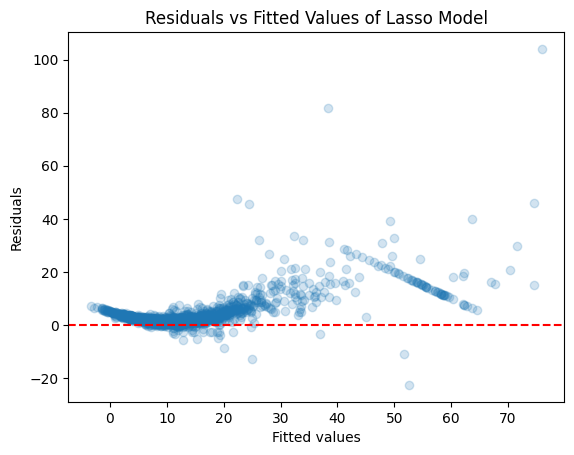

In [26]:
plt.scatter(predictions_and_residuals_lasso_pd['prediction'], predictions_and_residuals_lasso_pd['residuals'], alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Lasso Model: Residuals vs Fitted Values')
plt.show()

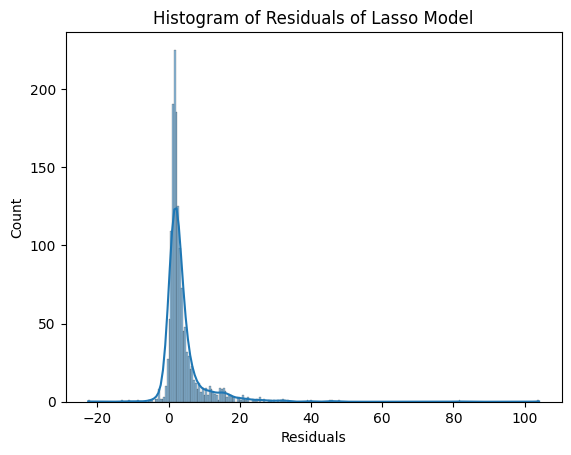

In [27]:
sns.histplot(predictions_and_residuals_lasso_pd['residuals'], kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals of Lasso Model')
plt.show()

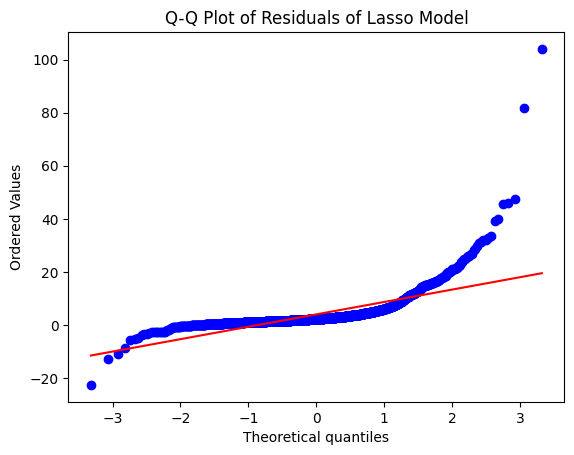

In [28]:
probplot(predictions_and_residuals_lasso_pd['residuals'], dist="norm", plot=plt)
plt.title('Lasso Model: Q-Q Plot of Residuals')
plt.show()

In [29]:
coefficients = lasso_model.coefficients

for feature, coeff in zip(relevant_columns, coefficients):
    print(f"Feature: {feature}, Coefficient: {coeff}")

Feature: VendorID, Coefficient: 0.0
Feature: trip_distance, Coefficient: 3.4532930522566048
Feature: RatecodeID, Coefficient: 2.857462303448214
Feature: PULocationID, Coefficient: 0.0
Feature: DOLocationID, Coefficient: 0.0
Feature: extra, Coefficient: -0.07341578536252197
Feature: mta_tax, Coefficient: -0.47847457169584856
Feature: tolls_amount, Coefficient: 0.868590423066157
Feature: improvement_surcharge, Coefficient: 0.0
Feature: congestion_surcharge, Coefficient: -0.4308437136574201
Feature: airport_fee, Coefficient: 0.2574787899031988
Feature: trip_duration_mins, Coefficient: 3.328181154249711
Feature: pickup_hour, Coefficient: -1.0447601675141
Feature: pickup_dayofweek, Coefficient: 0.009557079707008203
Feature: dropoff_hour, Coefficient: 0.0
Feature: dropoff_dayofweek, Coefficient: 0.0
Feature: days_since_2022_11_01, Coefficient: 0.06807917479278146
Feature: distance_time_interaction, Coefficient: 3.3645055897561393
Feature: is_airport_trip, Coefficient: 0.3862976443341288
Feat

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import DataFrame

def backward_elimination(data: DataFrame, features: list, label: str, stop_threshold=0.1):
    features_to_keep = features.copy()
    
    while len(features_to_keep) > 0:
        print(f"Training model with {len(features_to_keep)} features.")
        
        # Assemble the feature vector for current set of features
        assembler = VectorAssembler(inputCols=features_to_keep, outputCol="features")
        data_assembled = assembler.transform(data).select("features", label)
        
        # Train the model
        lr = LinearRegression(featuresCol="features", labelCol=label)
        lr_model = lr.fit(data_assembled)
        
        # Get the coefficients and associated features
        coefficients = lr_model.coefficients
        coef_feature_pairs = list(zip(coefficients, features_to_keep))
        
        # Find the least significant feature (smallest coefficient magnitude)
        least_significant_feature = min(coef_feature_pairs, key=lambda x: abs(x[0]))[1]
        
        # Check the magnitude of the smallest coefficient
        if abs(min(coef_feature_pairs, key=lambda x: abs(x[0]))[0]) < stop_threshold:
            print(f"Removing least significant feature: {least_significant_feature}")
            features_to_keep.remove(least_significant_feature)
        else:
            break
    
    print(f"Final set of features: {features_to_keep}")
    return features_to_keep

In [31]:
selected_features = backward_elimination(data=train_data, features=relevant_columns, label='fare_amount', stop_threshold=1.0)

Training model with 27 features.


24/08/21 13:32:45 WARN Instrumentation: [69a44af1] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: PULocationID
Training model with 26 features.


24/08/21 13:33:08 WARN Instrumentation: [8d8441f5] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: DOLocationID
Training model with 25 features.


24/08/21 13:33:31 WARN Instrumentation: [08abc3bc] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: days_since_2022_11_01
Training model with 24 features.


24/08/21 13:34:15 WARN Instrumentation: [816787c3] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: distance_time_interaction
Training model with 23 features.


24/08/21 13:34:46 WARN Instrumentation: [a543992c] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: dropoff_hour
Training model with 22 features.


24/08/21 13:35:18 WARN Instrumentation: [8489f494] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: dropoff_dayofweek
Training model with 21 features.


24/08/21 13:35:53 WARN Instrumentation: [3b281691] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pickup_hour
Training model with 20 features.


24/08/21 13:36:25 WARN Instrumentation: [f27c77e7] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pickup_at_airport
Training model with 19 features.


24/08/21 13:36:59 WARN Instrumentation: [0ea2e76c] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pickup_dayofweek
Training model with 18 features.


24/08/21 13:37:21 WARN Instrumentation: [c4e8de29] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: extra
Training model with 17 features.


24/08/21 13:37:46 WARN Instrumentation: [8fa578dc] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: is_event_day
Training model with 16 features.


24/08/21 13:38:06 WARN Instrumentation: [ac301288] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: VendorID
Training model with 15 features.


24/08/21 13:38:27 WARN Instrumentation: [96977c5b] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: avg_temp
Training model with 14 features.


24/08/21 13:38:47 WARN Instrumentation: [72cc3689] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: tolls_amount
Training model with 13 features.


24/08/21 13:39:22 WARN Instrumentation: [fedff071] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: congestion_surcharge
Training model with 12 features.


24/08/21 13:39:46 WARN Instrumentation: [801091eb] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pickup_at_tourist_attraction
Training model with 11 features.


24/08/21 13:40:18 WARN Instrumentation: [98994c7f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: is_tourist_trip
Training model with 10 features.


24/08/21 13:40:44 WARN Instrumentation: [0ba57eea] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: dropoff_at_tourist_attraction
Training model with 9 features.


24/08/21 13:41:04 WARN Instrumentation: [c9a56e28] regParam is zero, which might cause numerical instability and overfitting.


Final set of features: ['trip_distance', 'RatecodeID', 'mta_tax', 'improvement_surcharge', 'airport_fee', 'trip_duration_mins', 'is_airport_trip', 'dropoff_at_airport', 'is_holiday_season']


In [32]:
final_assembler = VectorAssembler(inputCols=selected_features, outputCol="final_features")
train_final = final_assembler.transform(train_data)
test_final = final_assembler.transform(test_data)

fare_scaler = StandardScaler(inputCol='final_features', outputCol='scaled_features')
fare_scaler_model = fare_scaler.fit(train_final)
fare_train_scaled = fare_scaler_model.transform(train_final).select('scaled_features', 'fare_amount')
fare_test_scaled = fare_scaler_model.transform(test_final).select('scaled_features', 'fare_amount')

In [33]:
final_lr = LinearRegression(featuresCol='scaled_features', labelCol='fare_amount')
final_model = final_lr.fit(fare_train_scaled)

test_predictions = final_model.transform(fare_test_scaled)
test_rmse = rmse_evaluator.evaluate(test_predictions)
test_mae = mae_evaluator.evaluate(test_predictions)
test_r2 = r2_evaluator.evaluate(test_predictions)

print(f"Final Model on Test Data -> RMSE: {test_rmse}, MAE: {test_mae}, R2: {test_r2}")

24/08/21 13:41:35 WARN Instrumentation: [4fb838f3] regParam is zero, which might cause numerical instability and overfitting.


Final Model on Test Data -> RMSE: 8.2017526506102, MAE: 5.359482836236612, R2: 0.7668100995718412


In [34]:
final_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/be_linear_model")